# Gráfica por Días



### Realizado por: Luis Mendoza Montero

- 1 - Cargar Paquetes
- 2 - Selección de Parámetros
- 3 - Preprocesado de datos para los Días
- 4 - Gráfica Precio Real Máximo


## 1. Cargar paquetes

In [1]:
import sqlite3
import csv
import sys
import numpy as np
import random
import pandas as pd
from glob import glob; from os.path import expanduser
from datetime import datetime, date, time, timedelta
import calendar
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

--------------------------------------------------------------------------------------------------------------------------------

## 2. Selección de Parámetros

### Seleccionar region y categoría (tabla de la BBDD)

In [2]:
region = "'M4_us_east_2'"

### Seleccionar tipo de Sistema Operativo

Existes 3 tipos de sistemas: ***Windows, Linux/UNIX o SUSE Linux***

In [3]:
sistema = "Linux/UNIX"

Sacamos las zonas de disponibilidad, los sistemas operativos y las fechas de las instancias

In [4]:
# Conectar con la base de datos
with sqlite3.connect("BBDD.db") as connection:
    
    # Sacamos el tipo de istancia (nombre + familia)
    instances = pd.read_sql("SELECT DISTINCT InstanceType FROM "+region+";", connection) 
    instances_list = instances.values.tolist()
    del instances_list[0]
    
    for inst in instances_list:
        instance=inst[0] # En la variable instance tenemos el tipo de instancia
    
    # Sacamos las zonas de disponibilidad
    zones = pd.read_sql("SELECT DISTINCT AvailabilityZone FROM "+region+";", connection) 
    zones_list = zones.values.tolist()
    del zones_list[0]
    
    listaRegiones = []
    for zone in zones_list:
        for zo in zone:
            listaRegiones.append(zo) # Lista de zonas en la región
    
    # Para cada zona y SO indicado sacamos el dia, el mes y el año
    for zona in listaRegiones: 
        dates = pd.read_sql("SELECT DISTINCT SUBSTR(Timestamp, 1, 10) FROM "+region+"WHERE AvailabilityZone = '"+zona+"'AND Description = '"+sistema+"';", connection)
        dates_list = dates.values.tolist()
    
    listaFechas = []
    for date in dates_list:
        for da in date:
            listaFechas.append(da) # Lista de fechas en cada zona y SO

# Cerrar la conexión siempre
connection.close()

### Seleccionar Zona de Disponibilidad

Elegir entre una de las siguientes zonas de disponibilidad:

In [5]:
print(listaRegiones)

['ap-southeast-1a', 'ap-southeast-1b', 'ap-southeast-1c']


In [6]:
zona = "us-east-2a"

### Seleccionar Fecha Inicio y Fin

In [7]:
f_inicio = '2018-02-01'
f_final = '2018-08-15'

--------------------------------------------------------------------------------------------------------------------------------

## 3. Preprocesado de datos para los Días

In [8]:
# Preprocesado por horas

# Conectar con la base de datos, si no existe la crea automáticamente
conexion = sqlite3.connect("BBDD.db")
    
# Para poder ejecutar código SQL, tenemos que crear un cursor primero, el nombre de la tabla será la familia de las categorías
cursor = conexion.cursor()
cursor.execute("DROP TABLE IF EXISTS Preprocesados;")
cursor.execute("CREATE TABLE IF NOT EXISTS Preprocesados (AvailabilityZone VARCHAR(100), Description VARCHAR(100), InstanceType VARCHAR(100), SpotPrice FLOAT(8,4), Timestamp Datetime, PRIMARY KEY('AvailabilityZone','InstanceType','Timestamp','Description'))")

# Insertamos los nombre de los atributos para que se tenga en cuenta en formato csv
cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ('AvailabilityZone','Description','InstanceType','SpotPrice','Timestamp');")      

lista = [] # variable auxiliar por si no hay precios en algunas horas para meter el anterior mayor
lista.append(0.0)
aux = '0'
for fecha in listaFechas:
            
            # Para las 00:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T00:00:00.000z' AND Timestamp <='"+fecha+"T00:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T00:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T00:00:00.000Z');")
                aux = str(precio)
                
            # Para las 01:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T01:00:00.000z' AND Timestamp <='"+fecha+"T01:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T01:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T01:00:00.000Z');")
                aux = str(precio)
           
            # Para las 02:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T02:00:00.000z' AND Timestamp <='"+fecha+"T02:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T02:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T02:00:00.000Z');")
                aux = str(precio)

                
            # Para las 03:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T03:00:00.000z' AND Timestamp <='"+fecha+"T03:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T03:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T03:00:00.000Z');")
                aux = str(precio)
    
                
            # Para las 04:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T04:00:00.000z' AND Timestamp <='"+fecha+"T04:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T04:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T04:00:00.000Z');")
                aux = str(precio)
                    
            
            # Para las 05:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T05:00:00.000z' AND Timestamp <='"+fecha+"T05:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T05:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T05:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 06:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T06:00:00.000z' AND Timestamp <='"+fecha+"T06:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T06:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T06:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 07:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T07:00:00.000z' AND Timestamp <='"+fecha+"T07:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T07:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T07:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 08:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T08:00:00.000z' AND Timestamp <='"+fecha+"T08:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T08:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T08:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 09:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T09:00:00.000z' AND Timestamp <='"+fecha+"T09:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T09:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T09:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 10:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T10:00:00.000z' AND Timestamp <='"+fecha+"T10:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T10:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T10:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 11:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T11:00:00.000z' AND Timestamp <='"+fecha+"T11:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T11:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T11:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 12:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T12:00:00.000z' AND Timestamp <='"+fecha+"T12:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T12:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T12:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 13:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T13:00:00.000z' AND Timestamp <='"+fecha+"T13:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T13:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T13:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 14:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T14:00:00.000z' AND Timestamp <='"+fecha+"T14:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T14:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T14:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 15:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T15:00:00.000z' AND Timestamp <='"+fecha+"T15:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T15:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T15:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 16:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T16:00:00.000z' AND Timestamp <='"+fecha+"T16:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T16:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T16:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 17:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T17:00:00.000z' AND Timestamp <='"+fecha+"T17:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T17:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T17:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 18:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T18:00:00.000z' AND Timestamp <='"+fecha+"T18:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T18:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T18:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 19:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T19:00:00.000z' AND Timestamp <='"+fecha+"T19:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T19:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T19:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 20:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T20:00:00.000z' AND Timestamp <='"+fecha+"T20:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T20:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T20:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 21:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T21:00:00.000z' AND Timestamp <='"+fecha+"T21:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T21:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T21:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 22:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T22:00:00.000z' AND Timestamp <='"+fecha+"T22:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T22:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T22:00:00.000Z');")
                aux = str(precio)
                    
                
            # Para las 23:00:00
            price = pd.read_sql("SELECT MAX(SpotPrice) FROM "+region+"WHERE SpotPrice<>'SpotPrice' AND AvailabilityZone='"+zona+"' AND Description = '"+sistema+"' AND Timestamp >='"+fecha+"T23:00:00.000z' AND Timestamp <='"+fecha+"T23:59:59.000z';",conexion)
            precios = price.values.tolist()
            for prec in precios:
                precio = str(prec[0])
            if precio == 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+aux+"','"+fecha+"T23:00:00.000Z');")
            elif precio != 'None':
                cursor.execute("INSERT OR IGNORE INTO Preprocesados VALUES ("+"'"+zona+"',"+"'"+sistema+"','"+instance+"','"+precio+"','"+fecha+"T23:00:00.000Z');")
                aux = str(precio)
                   

# Eliminamos los registros donde el precio sea 0
cursor.execute("DELETE FROM Preprocesados WHERE SpotPrice = 0.0")

# Guardamos los cambios haciendo un commit
conexion.commit()
    
# Cerrar la conexión siempre
connection.close()

# Conectar con la base de datos
with sqlite3.connect("BBDD.db") as connection:
    # Abrimos el csv a insertar los datos
    csvWriter = csv.writer(open("datos.csv", "w"))
    # Creamos el cursor
    c = connection.cursor()
    # Hacemos la consulta
    data = c.execute("SELECT * FROM Preprocesados ORDER BY Timestamp Desc") # Ordenamos los datos desde el más reciente al menos
    # Insertamos los datos en el dataset
    rows = data.fetchall()
    csvWriter.writerows(rows)

# Cerrar la conexión siempre
connection.close()

df = pd.read_csv("datos.csv")


In [9]:
# Preprocesado por días

for i,date in enumerate(df['Timestamp']):
    lista.append(date[:10])
lista2=[]  # En lista2 tengo los días
for e in lista:
    if e not in lista2:
        lista2.append(e)
lista2.reverse()

df2 = df.drop('AvailabilityZone', 1)
df2 = df2.drop('Description', 1)
df2 = df2.drop('InstanceType', 1)

price = []
lol = df2.values.tolist()
lol.reverse()

dfDays = pd.DataFrame(columns=['Periodo por días', 'Precio Real Max']) # Creamos el dataframe para los días

for fecha in lista2:
    for lista in lol:
        if (lista[1] == str(fecha)+"T23:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T22:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T21:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T20:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T19:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T18:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T17:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T16:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T15:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T14:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T13:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T12:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T11:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T10:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T09:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T08:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T07:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T06:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T05:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T04:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T03:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T02:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T01:00:00.000Z"):
            price.append(lista[0])
        if (lista[1] == str(fecha)+"T00:00:00.000Z"):
            price.append(lista[0])
    if price: # Si la lista no está vacía
        dfDays.loc[len(dfDays)]=[fecha,round(max(price),4)]
    price = []

In [10]:
# Seleccionamos el rango de días especificados por parámetro

dfDaysAux = dfDays[ dfDays['Periodo por días'] <= f_final ]
dfDays = dfDaysAux[ dfDaysAux['Periodo por días'] >= f_inicio ]
listaData = dfDays.values.tolist()
dfDays = pd.DataFrame(listaData,columns=['Periodo por días', 'Precio Real Max'])
dfDays

,Periodo por días,Precio Real Max
0,2018-02-01,0.2115
1,2018-02-02,0.2115
2,2018-02-03,0.2136
3,2018-02-04,0.2144
4,2018-02-05,0.2188
5,2018-02-06,0.2193
6,2018-02-07,0.2214
7,2018-02-08,0.2228
8,2018-02-09,0.2228
9,2018-02-10,0.2228


--------------------------------------------------------------------------------------------------------------------------------

## 4. Gráfica Precio Real Máximo

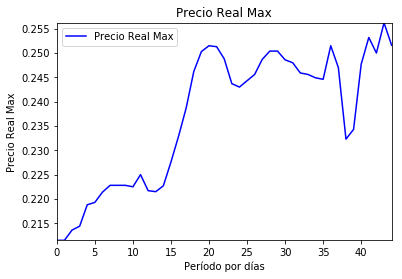

In [11]:
listDays = dfDays.values.tolist()
listAux = []
for x in range(0,len(listDays)):
    listAux.append(x)

x = listAux
y = dfDays['Precio Real Max']

figure()
plt.plot(x, y, 'r', color='b')
plt.axis([min(x),max(x),min(y),max(y)])
plt.legend()
xlabel('Período por días')
ylabel('Precio Real Max')
title('Precio Real Max')
show()

In [12]:
dfDays.to_csv('graficaDias.csv')